### Predict daily department sales of Walmart 
* Hybrid model - SARIMAX + LSTM
* Author: Reshma

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from math import sqrt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

In [3]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [4]:
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa.api as smt

### Sarima Rolling Forecast

In [15]:
def sarima_rolling_forecast(train_all, test_all, param_order, param_seasonal_order):
    
    history   =  train_all['sales'].values
    exo       =  np.array(train_all.drop('sales', axis=1))
    test_sale =  test_all['sales'].values
    exo_test  =  np.array(test_all.drop('sales', axis=1))
    model_sarima = smt.statespace.SARIMAX(endog=history, exog=exo,
                                      order         =param_order,
                                      seasonal_order=param_seasonal_order,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True )
    pred_dynamic = model_sarima.fit(start=pd.to_datetime('2011-01-29'), dynamic=False, 
                                           full_results=True)
    pred_sarima = pred_dynamic.fittedvalues[1000:]
    residuals   = pred_sarima-test_sale
        
    return pred_sarima, residuals

### Feed residuals to LSTM model

In [6]:
def model_LSTM(window_size):
    model = Sequential()
    model.add(Dense(50, input_dim=window_size, init="uniform",
    activation="tanh"))
    model.add(Dense(25, init="uniform", activation="tanh"))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def pred_resid_lstm(resid_test, lstm_test_len):
#     resid_test  = [[i] for i in resid_test]
    train_resid   = resid_test
#     test_resid    = resid_test[len(resid_test)  -lstm_test_len:]
    
    min_max_scaler = preprocessing.MinMaxScaler()
    train_lstm     = np.array(train_resid).reshape(-1,1)
    train_scaled   = min_max_scaler.fit_transform(train_lstm)
    
    print (len(train_lstm), len(train_scaled))
#     print (train_resid, test_resid)
    
    window_size =200
    
    train_X,train_Y = [],[]
    for i in range(0 , len(train_scaled) - window_size):
        train_X.append(train_scaled[i:i+window_size])
        train_Y.append(train_scaled[i+window_size])
    new_train_X,new_train_Y = [],[]
    for i in train_X:
        new_train_X.append(i.reshape(-1))
    for i in train_Y:
        new_train_Y.append(i.reshape(-1))
        
    new_train_X = np.array(new_train_X)
    new_train_Y = np.array(new_train_Y)
    
    model = model_LSTM(window_size)
    model.fit(new_train_X,new_train_Y, nb_epoch=500, batch_size=512, validation_split = 0.1)
    
    predictions         = model.predict(new_train_X)
    predictions_rescaled=min_max_scaler.inverse_transform(predictions)
    
    predictions_rescaled_flat =  [pred_sc[0] for pred_sc in predictions_rescaled]
    final_pred = pd.DataFrame()
    
    final_pred['resid_rescale'] = predictions_rescaled_flat
    final_pred['resid']         = predictions

    return final_pred

### Read data files

In [7]:
dataPath = 'exported_sales_data/WithoutChristmas/'
data  = pd.read_csv(dataPath+'sales_per_dept_with_price_events_noChristmas.csv')

In [8]:
data.set_index('dates', inplace=True)

In [9]:
sel_cols = ['dept_id', 'sales','event_name_1', 'event_name_2','snap_CA', 'snap_TX', 'snap_WI', 'sell_price_median', 'Is_weekday']

In [10]:
data_part = data[sel_cols]

In [11]:
dummy_cols = ['event_name_1', 'event_name_2']
data_dummy = pd.get_dummies(data_part, columns=dummy_cols)

In [12]:
# data_dummy

In [13]:
dept_ids = data_dummy['dept_id'].unique()

### Partition dataframe into department and run SARIMA and LSTM model

In [ ]:
###  R results of sARIMAX
'''
[1] "FOODS_1"

	Ljung-Box test

data:  Residuals from Regression with ARIMA(5,1,3)(2,0,0)[7] errors
Q* = 186.04, df = 3, p-value < 2.2e-16

Model df: 48.   Total lags used: 51

                       ME     RMSE      MAE        MPE      MAPE      MASE
Training set   -0.7631918 262.5058 186.8372 -0.6856301  7.124836 0.5648005
Test set     -248.5475824 331.4897 292.6334 -9.6291717 10.857391 0.8846176
                      ACF1
Training set -0.0009803038
Test set                NA
[1] "FOODS_2"

	Ljung-Box test

data:  Residuals from Regression with ARIMA(5,1,2)(2,0,1)[7] errors
Q* = 442.52, df = 3, p-value < 2.2e-16

Model df: 47.   Total lags used: 50

                     ME     RMSE      MAE        MPE      MAPE      MASE
Training set   2.535458 350.8436 270.6601 -0.8089025  7.012546 0.4843266
Test set     603.771261 875.6377 667.7077  8.9282477 10.395807 1.1948144
                     ACF1
Training set -0.000211708
Test set               NA
[1] "FOODS_3"

	Ljung-Box test

data:  Residuals from Regression with ARIMA(5,1,4)(1,0,2)[7] errors
Q* = 294.33, df = 3, p-value < 2.2e-16

Model df: 49.   Total lags used: 52

                    ME     RMSE       MAE        MPE     MAPE      MASE
Training set  24.87383 1229.721  921.5701 -0.4348899 5.557512 0.4159355
Test set     232.73801 1454.497 1188.5886  0.3339544 5.999622 0.5364499
                    ACF1
Training set 0.002564665
Test set              NA
[1] "HOBBIES_1"

	Ljung-Box test

data:  Residuals from Regression with ARIMA(2,1,1)(2,0,2)[7] errors
Q* = 232.24, df = 3, p-value < 2.2e-16

Model df: 44.   Total lags used: 47

                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set   6.554044 305.0182 227.5278 -0.7695344 8.016493 0.5630385
Test set     135.436641 346.5767 277.1668  2.7103968 7.369354 0.6858749
                      ACF1
Training set -0.0005736547
Test set                NA
[1] "HOBBIES_2"

	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,1,3)(1,0,0)[7] errors
Q* = 94.338, df = 3, p-value < 2.2e-16

Model df: 42.   Total lags used: 45

                    ME     RMSE      MAE       MPE     MAPE      MASE        ACF1
Training set  1.586942 45.68566 34.44778 -1.657003 13.38677 0.7783154 0.001130524
Test set     19.060152 48.09439 39.82124  3.561063 10.25558 0.8997237          NA
[1] "HOUSEHOLD_1"

	Ljung-Box test

data:  Residuals from Regression with ARIMA(3,1,1)(2,0,2)[7] errors
Q* = 353.19, df = 3, p-value < 2.2e-16

Model df: 45.   Total lags used: 48

                    ME     RMSE      MAE       MPE     MAPE      MASE         ACF1
Training set  18.42007 528.5990 391.6160 -0.220295 6.773046 0.4458883 -0.001524502
Test set     210.03526 812.2473 653.5961  1.042076 7.864446 0.7441751           NA
[1] "HOUSEHOLD_2"

	Ljung-Box test

data:  Residuals from Regression with ARIMA(3,1,1)(2,0,0)[7] errors
Q* = 313.51, df = 3, p-value < 2.2e-16

Model df: 43.   Total lags used: 46

                     ME     RMSE       MAE        MPE     MAPE      MASE
Training set   2.505404 121.8665  91.74407 -0.3688129 5.947549 0.4129758
Test set     108.249343 222.8700 168.98454  3.7559227 7.488694 0.7606653
                     ACF1
Training set -0.003459662
Test set               NA
'''

processing: FOODS_1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with Sarima
701 701
Train on 270 samples, validate on 30 samples
Epoch 1/500
270/270 [==============================] - 0s 400us/step - loss: 0.4571 - val_loss: 0.0610
Epoch 2/500
270/270 [==============================] - 0s 19us/step - loss: 0.0451 - val_loss: 0.0594
Epoch 3/500
270/270 [==============================] - 0s 19us/step - loss: 0.0518 - val_loss: 0.1351
Epoch 4/500
270/270 [==============================] - 0s 19us/step - loss: 0.1310 - val_loss: 0.1162
Epoch 5/500
270/270 [==============================] - 0s 19us/step - loss: 0.1115 - val_loss: 0.0589
Epoch 6/500
270/270 [==============================] - 0s 19us/step - loss: 0.0514 - val_loss: 0.0247
Epoch 7/500
270/270 [==============================] - 0s 15us/step - loss: 0.0136 - val_loss: 0.0353
Epoch 8/500
270/270 [==============================] - 0s 15us/step - loss: 0.0206 - val_loss: 0.0677
Epoch 9/500
270/270 [==============================] - 0s 19us/step - loss: 0.0505 - val_loss: 0.0850
Epoch 10/50

Epoch 80/500
270/270 [==============================] - 0s 22us/step - loss: 0.0112 - val_loss: 0.0231
Epoch 81/500
270/270 [==============================] - 0s 19us/step - loss: 0.0112 - val_loss: 0.0231
Epoch 82/500
270/270 [==============================] - 0s 19us/step - loss: 0.0112 - val_loss: 0.0230
Epoch 83/500
270/270 [==============================] - 0s 44us/step - loss: 0.0112 - val_loss: 0.0229
Epoch 84/500
270/270 [==============================] - 0s 22us/step - loss: 0.0112 - val_loss: 0.0229
Epoch 85/500
270/270 [==============================] - 0s 19us/step - loss: 0.0111 - val_loss: 0.0228
Epoch 86/500
270/270 [==============================] - 0s 22us/step - loss: 0.0112 - val_loss: 0.0228
Epoch 87/500
270/270 [==============================] - 0s 26us/step - loss: 0.0112 - val_loss: 0.0228
Epoch 88/500
270/270 [==============================] - 0s 22us/step - loss: 0.0112 - val_loss: 0.0228
Epoch 89/500
270/270 [==============================] - 0s 19us/step - lo

Epoch 159/500
270/270 [==============================] - 0s 19us/step - loss: 0.0106 - val_loss: 0.0226
Epoch 160/500
270/270 [==============================] - 0s 19us/step - loss: 0.0106 - val_loss: 0.0226
Epoch 161/500
270/270 [==============================] - 0s 19us/step - loss: 0.0106 - val_loss: 0.0226
Epoch 162/500
270/270 [==============================] - 0s 19us/step - loss: 0.0106 - val_loss: 0.0225
Epoch 163/500
270/270 [==============================] - 0s 22us/step - loss: 0.0106 - val_loss: 0.0225
Epoch 164/500
270/270 [==============================] - 0s 19us/step - loss: 0.0106 - val_loss: 0.0225
Epoch 165/500
270/270 [==============================] - 0s 22us/step - loss: 0.0106 - val_loss: 0.0225
Epoch 166/500
270/270 [==============================] - 0s 22us/step - loss: 0.0105 - val_loss: 0.0225
Epoch 167/500
270/270 [==============================] - 0s 22us/step - loss: 0.0105 - val_loss: 0.0225
Epoch 168/500
270/270 [==============================] - 0s 22us

Epoch 238/500
270/270 [==============================] - 0s 22us/step - loss: 0.0091 - val_loss: 0.0218
Epoch 239/500
270/270 [==============================] - 0s 22us/step - loss: 0.0091 - val_loss: 0.0217
Epoch 240/500
270/270 [==============================] - 0s 22us/step - loss: 0.0091 - val_loss: 0.0217
Epoch 241/500
270/270 [==============================] - 0s 19us/step - loss: 0.0090 - val_loss: 0.0217
Epoch 242/500
270/270 [==============================] - 0s 19us/step - loss: 0.0090 - val_loss: 0.0217
Epoch 243/500
270/270 [==============================] - 0s 22us/step - loss: 0.0090 - val_loss: 0.0217
Epoch 244/500
270/270 [==============================] - 0s 26us/step - loss: 0.0089 - val_loss: 0.0217
Epoch 245/500
270/270 [==============================] - 0s 37us/step - loss: 0.0089 - val_loss: 0.0217
Epoch 246/500
270/270 [==============================] - 0s 26us/step - loss: 0.0089 - val_loss: 0.0216
Epoch 247/500
270/270 [==============================] - 0s 19us

Epoch 317/500
270/270 [==============================] - 0s 19us/step - loss: 0.0062 - val_loss: 0.0215
Epoch 318/500
270/270 [==============================] - 0s 15us/step - loss: 0.0061 - val_loss: 0.0215
Epoch 319/500
270/270 [==============================] - 0s 15us/step - loss: 0.0061 - val_loss: 0.0216
Epoch 320/500
270/270 [==============================] - 0s 19us/step - loss: 0.0061 - val_loss: 0.0216
Epoch 321/500
270/270 [==============================] - 0s 15us/step - loss: 0.0060 - val_loss: 0.0216
Epoch 322/500
270/270 [==============================] - 0s 15us/step - loss: 0.0060 - val_loss: 0.0216
Epoch 323/500
270/270 [==============================] - 0s 15us/step - loss: 0.0059 - val_loss: 0.0217
Epoch 324/500
270/270 [==============================] - 0s 30us/step - loss: 0.0059 - val_loss: 0.0217
Epoch 325/500
270/270 [==============================] - 0s 19us/step - loss: 0.0059 - val_loss: 0.0217
Epoch 326/500
270/270 [==============================] - 0s 19us

Epoch 396/500
270/270 [==============================] - 0s 19us/step - loss: 0.0043 - val_loss: 0.0252
Epoch 397/500
270/270 [==============================] - 0s 15us/step - loss: 0.0047 - val_loss: 0.0241
Epoch 398/500
270/270 [==============================] - 0s 11us/step - loss: 0.0041 - val_loss: 0.0234
Epoch 399/500
270/270 [==============================] - 0s 19us/step - loss: 0.0047 - val_loss: 0.0236
Epoch 400/500
270/270 [==============================] - 0s 15us/step - loss: 0.0039 - val_loss: 0.0252
Epoch 401/500
270/270 [==============================] - 0s 19us/step - loss: 0.0045 - val_loss: 0.0236
Epoch 402/500
270/270 [==============================] - 0s 15us/step - loss: 0.0039 - val_loss: 0.0235
Epoch 403/500
270/270 [==============================] - 0s 15us/step - loss: 0.0043 - val_loss: 0.0242
Epoch 404/500
270/270 [==============================] - 0s 19us/step - loss: 0.0040 - val_loss: 0.0246
Epoch 405/500
270/270 [==============================] - 0s 15us

Epoch 475/500
270/270 [==============================] - 0s 15us/step - loss: 0.0028 - val_loss: 0.0264
Epoch 476/500
270/270 [==============================] - 0s 15us/step - loss: 0.0028 - val_loss: 0.0265
Epoch 477/500
270/270 [==============================] - 0s 19us/step - loss: 0.0027 - val_loss: 0.0265
Epoch 478/500
270/270 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0265
Epoch 479/500
270/270 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0265
Epoch 480/500
270/270 [==============================] - 0s 22us/step - loss: 0.0027 - val_loss: 0.0266
Epoch 481/500
270/270 [==============================] - 0s 19us/step - loss: 0.0027 - val_loss: 0.0266
Epoch 482/500
270/270 [==============================] - 0s 19us/step - loss: 0.0027 - val_loss: 0.0266
Epoch 483/500
270/270 [==============================] - 0s 15us/step - loss: 0.0027 - val_loss: 0.0267
Epoch 484/500
270/270 [==============================] - 0s 19us

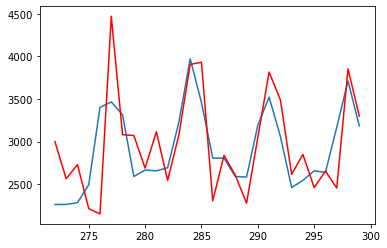

processing: FOODS_2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with Sarima
701 701
Train on 270 samples, validate on 30 samples
Epoch 1/500
270/270 [==============================] - 0s 352us/step - loss: 0.2491 - val_loss: 0.0594
Epoch 2/500
270/270 [==============================] - 0s 15us/step - loss: 0.0603 - val_loss: 0.0334
Epoch 3/500
270/270 [==============================] - 0s 15us/step - loss: 0.0305 - val_loss: 0.0756
Epoch 4/500
270/270 [==============================] - 0s 19us/step - loss: 0.0707 - val_loss: 0.0741
Epoch 5/500
270/270 [==============================] - 0s 15us/step - loss: 0.0694 - val_loss: 0.0452
Epoch 6/500
270/270 [==============================] - 0s 15us/step - loss: 0.0417 - val_loss: 0.0272
Epoch 7/500
270/270 [==============================] - 0s 19us/step - loss: 0.0255 - val_loss: 0.0348
Epoch 8/500
270/270 [==============================] - 0s 15us/step - loss: 0.0351 - val_loss: 0.0501
Epoch 9/500
270/270 [==============================] - 0s 19us/step - loss: 0.0515 - val_loss: 0.0500
Epoch 10/50

Epoch 80/500
270/270 [==============================] - 0s 15us/step - loss: 0.0231 - val_loss: 0.0259
Epoch 81/500
270/270 [==============================] - 0s 15us/step - loss: 0.0230 - val_loss: 0.0259
Epoch 82/500
270/270 [==============================] - 0s 22us/step - loss: 0.0229 - val_loss: 0.0259
Epoch 83/500
270/270 [==============================] - 0s 19us/step - loss: 0.0228 - val_loss: 0.0258
Epoch 84/500
270/270 [==============================] - 0s 19us/step - loss: 0.0227 - val_loss: 0.0257
Epoch 85/500
270/270 [==============================] - 0s 15us/step - loss: 0.0226 - val_loss: 0.0257
Epoch 86/500
270/270 [==============================] - 0s 15us/step - loss: 0.0225 - val_loss: 0.0256
Epoch 87/500
270/270 [==============================] - 0s 15us/step - loss: 0.0224 - val_loss: 0.0256
Epoch 88/500
270/270 [==============================] - 0s 15us/step - loss: 0.0223 - val_loss: 0.0256
Epoch 89/500
270/270 [==============================] - 0s 19us/step - lo

Epoch 159/500
270/270 [==============================] - 0s 19us/step - loss: 0.0103 - val_loss: 0.0275
Epoch 160/500
270/270 [==============================] - 0s 15us/step - loss: 0.0100 - val_loss: 0.0267
Epoch 161/500
270/270 [==============================] - 0s 19us/step - loss: 0.0087 - val_loss: 0.0293
Epoch 162/500
270/270 [==============================] - 0s 19us/step - loss: 0.0102 - val_loss: 0.0268
Epoch 163/500
270/270 [==============================] - 0s 22us/step - loss: 0.0083 - val_loss: 0.0276
Epoch 164/500
270/270 [==============================] - 0s 19us/step - loss: 0.0095 - val_loss: 0.0280
Epoch 165/500
270/270 [==============================] - 0s 15us/step - loss: 0.0088 - val_loss: 0.0277
Epoch 166/500
270/270 [==============================] - 0s 15us/step - loss: 0.0085 - val_loss: 0.0276
Epoch 167/500
270/270 [==============================] - 0s 19us/step - loss: 0.0091 - val_loss: 0.0272
Epoch 168/500
270/270 [==============================] - 0s 15us

Epoch 238/500
270/270 [==============================] - 0s 15us/step - loss: 0.0059 - val_loss: 0.0336
Epoch 239/500
270/270 [==============================] - 0s 15us/step - loss: 0.0058 - val_loss: 0.0319
Epoch 240/500
270/270 [==============================] - 0s 15us/step - loss: 0.0047 - val_loss: 0.0320
Epoch 241/500
270/270 [==============================] - 0s 19us/step - loss: 0.0048 - val_loss: 0.0334
Epoch 242/500
270/270 [==============================] - 0s 19us/step - loss: 0.0055 - val_loss: 0.0323
Epoch 243/500
270/270 [==============================] - 0s 19us/step - loss: 0.0051 - val_loss: 0.0321
Epoch 244/500
270/270 [==============================] - 0s 15us/step - loss: 0.0045 - val_loss: 0.0326
Epoch 245/500
270/270 [==============================] - 0s 19us/step - loss: 0.0048 - val_loss: 0.0324
Epoch 246/500
270/270 [==============================] - 0s 19us/step - loss: 0.0051 - val_loss: 0.0327
Epoch 247/500
270/270 [==============================] - 0s 15us

Epoch 317/500
270/270 [==============================] - 0s 15us/step - loss: 0.0037 - val_loss: 0.0341
Epoch 318/500
270/270 [==============================] - 0s 15us/step - loss: 0.0038 - val_loss: 0.0337
Epoch 319/500
270/270 [==============================] - 0s 15us/step - loss: 0.0032 - val_loss: 0.0344
Epoch 320/500
270/270 [==============================] - 0s 15us/step - loss: 0.0036 - val_loss: 0.0340
Epoch 321/500
270/270 [==============================] - 0s 15us/step - loss: 0.0035 - val_loss: 0.0338
Epoch 322/500
270/270 [==============================] - 0s 19us/step - loss: 0.0031 - val_loss: 0.0345
Epoch 323/500
270/270 [==============================] - 0s 15us/step - loss: 0.0035 - val_loss: 0.0340
Epoch 324/500
270/270 [==============================] - 0s 15us/step - loss: 0.0033 - val_loss: 0.0340
Epoch 325/500
270/270 [==============================] - 0s 19us/step - loss: 0.0031 - val_loss: 0.0345
Epoch 326/500
270/270 [==============================] - 0s 19us

Epoch 396/500
270/270 [==============================] - 0s 26us/step - loss: 0.0022 - val_loss: 0.0369
Epoch 397/500
270/270 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0369
Epoch 398/500
270/270 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0370
Epoch 399/500
270/270 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 0.0370
Epoch 400/500
270/270 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0371
Epoch 401/500
270/270 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0371
Epoch 402/500
270/270 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0374
Epoch 403/500
270/270 [==============================] - 0s 19us/step - loss: 0.0024 - val_loss: 0.0378
Epoch 404/500
270/270 [==============================] - 0s 19us/step - loss: 0.0029 - val_loss: 0.0389
Epoch 405/500
270/270 [==============================] - 0s 22us

Epoch 475/500
270/270 [==============================] - 0s 26us/step - loss: 0.0017 - val_loss: 0.0378
Epoch 476/500
270/270 [==============================] - 0s 19us/step - loss: 0.0017 - val_loss: 0.0378
Epoch 477/500
270/270 [==============================] - 0s 22us/step - loss: 0.0017 - val_loss: 0.0378
Epoch 478/500
270/270 [==============================] - 0s 22us/step - loss: 0.0017 - val_loss: 0.0379
Epoch 479/500
270/270 [==============================] - 0s 22us/step - loss: 0.0017 - val_loss: 0.0379
Epoch 480/500
270/270 [==============================] - 0s 19us/step - loss: 0.0017 - val_loss: 0.0379
Epoch 481/500
270/270 [==============================] - 0s 22us/step - loss: 0.0017 - val_loss: 0.0379
Epoch 482/500
270/270 [==============================] - 0s 19us/step - loss: 0.0017 - val_loss: 0.0380
Epoch 483/500
270/270 [==============================] - 0s 22us/step - loss: 0.0017 - val_loss: 0.0380
Epoch 484/500
270/270 [==============================] - 0s 19us

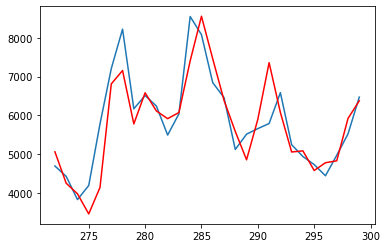

processing: FOODS_3


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with Sarima
701 701
Train on 270 samples, validate on 30 samples
Epoch 1/500
270/270 [==============================] - 0s 348us/step - loss: 0.2216 - val_loss: 0.0149
Epoch 2/500
270/270 [==============================] - 0s 26us/step - loss: 0.0159 - val_loss: 0.0663
Epoch 3/500
270/270 [==============================] - 0s 15us/step - loss: 0.0643 - val_loss: 0.0822
Epoch 4/500
270/270 [==============================] - 0s 19us/step - loss: 0.0799 - val_loss: 0.0413
Epoch 5/500
270/270 [==============================] - 0s 19us/step - loss: 0.0397 - val_loss: 0.0146
Epoch 6/500
270/270 [==============================] - 0s 15us/step - loss: 0.0145 - val_loss: 0.0204
Epoch 7/500
270/270 [==============================] - 0s 19us/step - loss: 0.0221 - val_loss: 0.0361
Epoch 8/500
270/270 [==============================] - 0s 19us/step - loss: 0.0389 - val_loss: 0.0394
Epoch 9/500
270/270 [==============================] - 0s 15us/step - loss: 0.0424 - val_loss: 0.0294
Epoch 10/50

Epoch 80/500
270/270 [==============================] - 0s 15us/step - loss: 0.0128 - val_loss: 0.0132
Epoch 81/500
270/270 [==============================] - 0s 19us/step - loss: 0.0128 - val_loss: 0.0132
Epoch 82/500
270/270 [==============================] - 0s 19us/step - loss: 0.0128 - val_loss: 0.0132
Epoch 83/500
270/270 [==============================] - 0s 15us/step - loss: 0.0127 - val_loss: 0.0132
Epoch 84/500
270/270 [==============================] - 0s 15us/step - loss: 0.0127 - val_loss: 0.0132
Epoch 85/500
270/270 [==============================] - 0s 15us/step - loss: 0.0127 - val_loss: 0.0132
Epoch 86/500
270/270 [==============================] - 0s 15us/step - loss: 0.0127 - val_loss: 0.0132
Epoch 87/500
270/270 [==============================] - 0s 15us/step - loss: 0.0127 - val_loss: 0.0132
Epoch 88/500
270/270 [==============================] - 0s 15us/step - loss: 0.0127 - val_loss: 0.0132
Epoch 89/500
270/270 [==============================] - 0s 15us/step - lo

Epoch 159/500
270/270 [==============================] - 0s 26us/step - loss: 0.0095 - val_loss: 0.0126
Epoch 160/500
270/270 [==============================] - 0s 15us/step - loss: 0.0095 - val_loss: 0.0126
Epoch 161/500
270/270 [==============================] - 0s 15us/step - loss: 0.0094 - val_loss: 0.0126
Epoch 162/500
270/270 [==============================] - 0s 18us/step - loss: 0.0093 - val_loss: 0.0126
Epoch 163/500
270/270 [==============================] - 0s 22us/step - loss: 0.0092 - val_loss: 0.0126
Epoch 164/500
270/270 [==============================] - 0s 18us/step - loss: 0.0092 - val_loss: 0.0126
Epoch 165/500
270/270 [==============================] - 0s 15us/step - loss: 0.0091 - val_loss: 0.0126
Epoch 166/500
270/270 [==============================] - 0s 15us/step - loss: 0.0090 - val_loss: 0.0126
Epoch 167/500
270/270 [==============================] - 0s 19us/step - loss: 0.0089 - val_loss: 0.0126
Epoch 168/500
270/270 [==============================] - 0s 22us

Epoch 238/500
270/270 [==============================] - 0s 26us/step - loss: 0.0047 - val_loss: 0.0140
Epoch 239/500
270/270 [==============================] - 0s 19us/step - loss: 0.0048 - val_loss: 0.0144
Epoch 240/500
270/270 [==============================] - 0s 22us/step - loss: 0.0049 - val_loss: 0.0139
Epoch 241/500
270/270 [==============================] - 0s 33us/step - loss: 0.0045 - val_loss: 0.0141
Epoch 242/500
270/270 [==============================] - 0s 22us/step - loss: 0.0048 - val_loss: 0.0143
Epoch 243/500
270/270 [==============================] - 0s 22us/step - loss: 0.0046 - val_loss: 0.0141
Epoch 244/500
270/270 [==============================] - 0s 33us/step - loss: 0.0044 - val_loss: 0.0142
Epoch 245/500
270/270 [==============================] - 0s 41us/step - loss: 0.0046 - val_loss: 0.0142
Epoch 246/500
270/270 [==============================] - 0s 19us/step - loss: 0.0045 - val_loss: 0.0142
Epoch 247/500
270/270 [==============================] - 0s 22us

Epoch 317/500
270/270 [==============================] - 0s 26us/step - loss: 0.0030 - val_loss: 0.0158
Epoch 318/500
270/270 [==============================] - 0s 19us/step - loss: 0.0028 - val_loss: 0.0160
Epoch 319/500
270/270 [==============================] - 0s 19us/step - loss: 0.0030 - val_loss: 0.0161
Epoch 320/500
270/270 [==============================] - 0s 19us/step - loss: 0.0030 - val_loss: 0.0159
Epoch 321/500
270/270 [==============================] - 0s 22us/step - loss: 0.0028 - val_loss: 0.0159
Epoch 322/500
270/270 [==============================] - 0s 22us/step - loss: 0.0028 - val_loss: 0.0162
Epoch 323/500
270/270 [==============================] - 0s 22us/step - loss: 0.0029 - val_loss: 0.0160
Epoch 324/500
270/270 [==============================] - 0s 22us/step - loss: 0.0029 - val_loss: 0.0160
Epoch 325/500
270/270 [==============================] - 0s 19us/step - loss: 0.0027 - val_loss: 0.0161
Epoch 326/500
270/270 [==============================] - 0s 22us

Epoch 396/500
270/270 [==============================] - 0s 22us/step - loss: 0.0023 - val_loss: 0.0169
Epoch 397/500
270/270 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 0.0172
Epoch 398/500
270/270 [==============================] - 0s 19us/step - loss: 0.0024 - val_loss: 0.0170
Epoch 399/500
270/270 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 0.0171
Epoch 400/500
270/270 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0172
Epoch 401/500
270/270 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 0.0171
Epoch 402/500
270/270 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 0.0173
Epoch 403/500
270/270 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 0.0173
Epoch 404/500
270/270 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 0.0172
Epoch 405/500
270/270 [==============================] - 0s 19us

Epoch 475/500
270/270 [==============================] - 0s 22us/step - loss: 0.0015 - val_loss: 0.0189
Epoch 476/500
270/270 [==============================] - 0s 19us/step - loss: 0.0015 - val_loss: 0.0190
Epoch 477/500
270/270 [==============================] - 0s 19us/step - loss: 0.0015 - val_loss: 0.0189
Epoch 478/500
270/270 [==============================] - 0s 15us/step - loss: 0.0015 - val_loss: 0.0191
Epoch 479/500
270/270 [==============================] - 0s 19us/step - loss: 0.0015 - val_loss: 0.0190
Epoch 480/500
270/270 [==============================] - 0s 15us/step - loss: 0.0016 - val_loss: 0.0195
Epoch 481/500
270/270 [==============================] - 0s 22us/step - loss: 0.0018 - val_loss: 0.0196
Epoch 482/500
270/270 [==============================] - 0s 22us/step - loss: 0.0023 - val_loss: 0.0211
Epoch 483/500
270/270 [==============================] - 0s 19us/step - loss: 0.0033 - val_loss: 0.0226
Epoch 484/500
270/270 [==============================] - 0s 15us

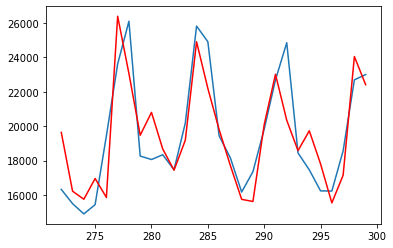

processing: HOBBIES_1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with Sarima
701 701
Train on 270 samples, validate on 30 samples
Epoch 1/500
270/270 [==============================] - 0s 337us/step - loss: 0.2682 - val_loss: 0.0278
Epoch 2/500
270/270 [==============================] - 0s 19us/step - loss: 0.0332 - val_loss: 0.0441
Epoch 3/500
270/270 [==============================] - 0s 18us/step - loss: 0.0397 - val_loss: 0.0889
Epoch 4/500
270/270 [==============================] - 0s 15us/step - loss: 0.0815 - val_loss: 0.0687
Epoch 5/500
270/270 [==============================] - 0s 19us/step - loss: 0.0625 - val_loss: 0.0289
Epoch 6/500
270/270 [==============================] - 0s 18us/step - loss: 0.0260 - val_loss: 0.0107
Epoch 7/500
270/270 [==============================] - 0s 18us/step - loss: 0.0117 - val_loss: 0.0197
Epoch 8/500
270/270 [==============================] - 0s 19us/step - loss: 0.0241 - val_loss: 0.0346
Epoch 9/500
270/270 [==============================] - 0s 15us/step - loss: 0.0409 - val_loss: 0.0366
Epoch 10/50

Epoch 80/500
270/270 [==============================] - 0s 15us/step - loss: 0.0111 - val_loss: 0.0105
Epoch 81/500
270/270 [==============================] - 0s 19us/step - loss: 0.0111 - val_loss: 0.0105
Epoch 82/500
270/270 [==============================] - 0s 15us/step - loss: 0.0111 - val_loss: 0.0105
Epoch 83/500
270/270 [==============================] - 0s 15us/step - loss: 0.0111 - val_loss: 0.0104
Epoch 84/500
270/270 [==============================] - 0s 19us/step - loss: 0.0111 - val_loss: 0.0103
Epoch 85/500
270/270 [==============================] - 0s 15us/step - loss: 0.0111 - val_loss: 0.0103
Epoch 86/500
270/270 [==============================] - 0s 19us/step - loss: 0.0111 - val_loss: 0.0102
Epoch 87/500
270/270 [==============================] - 0s 15us/step - loss: 0.0110 - val_loss: 0.0102
Epoch 88/500
270/270 [==============================] - 0s 19us/step - loss: 0.0110 - val_loss: 0.0102
Epoch 89/500
270/270 [==============================] - 0s 15us/step - lo

Epoch 159/500
270/270 [==============================] - 0s 19us/step - loss: 0.0097 - val_loss: 0.0092
Epoch 160/500
270/270 [==============================] - 0s 18us/step - loss: 0.0096 - val_loss: 0.0092
Epoch 161/500
270/270 [==============================] - 0s 22us/step - loss: 0.0096 - val_loss: 0.0091
Epoch 162/500
270/270 [==============================] - 0s 15us/step - loss: 0.0096 - val_loss: 0.0091
Epoch 163/500
270/270 [==============================] - 0s 19us/step - loss: 0.0095 - val_loss: 0.0091
Epoch 164/500
270/270 [==============================] - 0s 19us/step - loss: 0.0095 - val_loss: 0.0090
Epoch 165/500
270/270 [==============================] - 0s 22us/step - loss: 0.0094 - val_loss: 0.0090
Epoch 166/500
270/270 [==============================] - 0s 19us/step - loss: 0.0094 - val_loss: 0.0090
Epoch 167/500
270/270 [==============================] - 0s 26us/step - loss: 0.0094 - val_loss: 0.0090
Epoch 168/500
270/270 [==============================] - 0s 22us

Epoch 238/500
270/270 [==============================] - 0s 22us/step - loss: 0.0050 - val_loss: 0.0064
Epoch 239/500
270/270 [==============================] - 0s 22us/step - loss: 0.0050 - val_loss: 0.0064
Epoch 240/500
270/270 [==============================] - 0s 22us/step - loss: 0.0049 - val_loss: 0.0064
Epoch 241/500
270/270 [==============================] - 0s 26us/step - loss: 0.0049 - val_loss: 0.0064
Epoch 242/500
270/270 [==============================] - 0s 22us/step - loss: 0.0048 - val_loss: 0.0063
Epoch 243/500
270/270 [==============================] - 0s 19us/step - loss: 0.0048 - val_loss: 0.0063
Epoch 244/500
270/270 [==============================] - 0s 22us/step - loss: 0.0047 - val_loss: 0.0063
Epoch 245/500
270/270 [==============================] - 0s 19us/step - loss: 0.0046 - val_loss: 0.0063
Epoch 246/500
270/270 [==============================] - 0s 19us/step - loss: 0.0046 - val_loss: 0.0063
Epoch 247/500
270/270 [==============================] - 0s 19us

Epoch 317/500
270/270 [==============================] - 0s 19us/step - loss: 0.0029 - val_loss: 0.0062
Epoch 318/500
270/270 [==============================] - 0s 22us/step - loss: 0.0029 - val_loss: 0.0063
Epoch 319/500
270/270 [==============================] - 0s 22us/step - loss: 0.0029 - val_loss: 0.0064
Epoch 320/500
270/270 [==============================] - 0s 19us/step - loss: 0.0029 - val_loss: 0.0062
Epoch 321/500
270/270 [==============================] - 0s 22us/step - loss: 0.0028 - val_loss: 0.0064
Epoch 322/500
270/270 [==============================] - 0s 22us/step - loss: 0.0028 - val_loss: 0.0063
Epoch 323/500
270/270 [==============================] - 0s 19us/step - loss: 0.0028 - val_loss: 0.0064
Epoch 324/500
270/270 [==============================] - 0s 19us/step - loss: 0.0028 - val_loss: 0.0064
Epoch 325/500
270/270 [==============================] - 0s 22us/step - loss: 0.0028 - val_loss: 0.0063
Epoch 326/500
270/270 [==============================] - 0s 19us

Epoch 396/500
270/270 [==============================] - 0s 19us/step - loss: 0.0020 - val_loss: 0.0068
Epoch 397/500
270/270 [==============================] - 0s 19us/step - loss: 0.0020 - val_loss: 0.0067
Epoch 398/500
270/270 [==============================] - 0s 22us/step - loss: 0.0020 - val_loss: 0.0066
Epoch 399/500
270/270 [==============================] - 0s 19us/step - loss: 0.0020 - val_loss: 0.0069
Epoch 400/500
270/270 [==============================] - 0s 22us/step - loss: 0.0020 - val_loss: 0.0065
Epoch 401/500
270/270 [==============================] - 0s 15us/step - loss: 0.0020 - val_loss: 0.0068
Epoch 402/500
270/270 [==============================] - 0s 19us/step - loss: 0.0020 - val_loss: 0.0067
Epoch 403/500
270/270 [==============================] - 0s 22us/step - loss: 0.0019 - val_loss: 0.0066
Epoch 404/500
270/270 [==============================] - 0s 22us/step - loss: 0.0019 - val_loss: 0.0069
Epoch 405/500
270/270 [==============================] - 0s 19us

Epoch 475/500
270/270 [==============================] - 0s 19us/step - loss: 0.0015 - val_loss: 0.0069
Epoch 476/500
270/270 [==============================] - 0s 15us/step - loss: 0.0016 - val_loss: 0.0075
Epoch 477/500
270/270 [==============================] - 0s 19us/step - loss: 0.0016 - val_loss: 0.0070
Epoch 478/500
270/270 [==============================] - 0s 15us/step - loss: 0.0015 - val_loss: 0.0071
Epoch 479/500
270/270 [==============================] - 0s 15us/step - loss: 0.0015 - val_loss: 0.0074
Epoch 480/500
270/270 [==============================] - 0s 15us/step - loss: 0.0015 - val_loss: 0.0069
Epoch 481/500
270/270 [==============================] - 0s 22us/step - loss: 0.0015 - val_loss: 0.0073
Epoch 482/500
270/270 [==============================] - 0s 15us/step - loss: 0.0015 - val_loss: 0.0072
Epoch 483/500
270/270 [==============================] - 0s 11us/step - loss: 0.0015 - val_loss: 0.0070
Epoch 484/500
270/270 [==============================] - 0s 19us

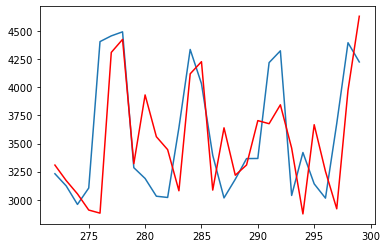

processing: HOBBIES_2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with Sarima
701 701
Train on 270 samples, validate on 30 samples
Epoch 1/500
270/270 [==============================] - 0s 333us/step - loss: 0.2118 - val_loss: 0.0287
Epoch 2/500
270/270 [==============================] - 0s 22us/step - loss: 0.0367 - val_loss: 0.0344
Epoch 3/500
270/270 [==============================] - 0s 19us/step - loss: 0.0360 - val_loss: 0.0756
Epoch 4/500
270/270 [==============================] - 0s 19us/step - loss: 0.0741 - val_loss: 0.0628
Epoch 5/500
270/270 [==============================] - 0s 15us/step - loss: 0.0623 - val_loss: 0.0311
Epoch 6/500
270/270 [==============================] - 0s 15us/step - loss: 0.0332 - val_loss: 0.0138
Epoch 7/500
270/270 [==============================] - 0s 19us/step - loss: 0.0187 - val_loss: 0.0187
Epoch 8/500
270/270 [==============================] - 0s 19us/step - loss: 0.0257 - val_loss: 0.0314
Epoch 9/500
270/270 [==============================] - 0s 19us/step - loss: 0.0396 - val_loss: 0.0358
Epoch 10/50

Epoch 80/500
270/270 [==============================] - 0s 15us/step - loss: 0.0175 - val_loss: 0.0130
Epoch 81/500
270/270 [==============================] - 0s 19us/step - loss: 0.0175 - val_loss: 0.0129
Epoch 82/500
270/270 [==============================] - 0s 15us/step - loss: 0.0175 - val_loss: 0.0129
Epoch 83/500
270/270 [==============================] - 0s 19us/step - loss: 0.0175 - val_loss: 0.0129
Epoch 84/500
270/270 [==============================] - 0s 15us/step - loss: 0.0175 - val_loss: 0.0130
Epoch 85/500
270/270 [==============================] - 0s 19us/step - loss: 0.0174 - val_loss: 0.0130
Epoch 86/500
270/270 [==============================] - 0s 15us/step - loss: 0.0174 - val_loss: 0.0130
Epoch 87/500
270/270 [==============================] - 0s 15us/step - loss: 0.0174 - val_loss: 0.0130
Epoch 88/500
270/270 [==============================] - 0s 15us/step - loss: 0.0174 - val_loss: 0.0131
Epoch 89/500
270/270 [==============================] - 0s 15us/step - lo

Epoch 159/500
270/270 [==============================] - 0s 19us/step - loss: 0.0117 - val_loss: 0.0141
Epoch 160/500
270/270 [==============================] - 0s 19us/step - loss: 0.0116 - val_loss: 0.0141
Epoch 161/500
270/270 [==============================] - 0s 15us/step - loss: 0.0114 - val_loss: 0.0142
Epoch 162/500
270/270 [==============================] - 0s 15us/step - loss: 0.0112 - val_loss: 0.0142
Epoch 163/500
270/270 [==============================] - 0s 15us/step - loss: 0.0111 - val_loss: 0.0143
Epoch 164/500
270/270 [==============================] - 0s 19us/step - loss: 0.0109 - val_loss: 0.0143
Epoch 165/500
270/270 [==============================] - 0s 19us/step - loss: 0.0108 - val_loss: 0.0144
Epoch 166/500
270/270 [==============================] - 0s 19us/step - loss: 0.0106 - val_loss: 0.0145
Epoch 167/500
270/270 [==============================] - 0s 22us/step - loss: 0.0104 - val_loss: 0.0145
Epoch 168/500
270/270 [==============================] - 0s 19us

Epoch 238/500
270/270 [==============================] - 0s 19us/step - loss: 0.0040 - val_loss: 0.0189
Epoch 239/500
270/270 [==============================] - 0s 19us/step - loss: 0.0040 - val_loss: 0.0192
Epoch 240/500
270/270 [==============================] - 0s 15us/step - loss: 0.0039 - val_loss: 0.0193
Epoch 241/500
270/270 [==============================] - 0s 22us/step - loss: 0.0039 - val_loss: 0.0191
Epoch 242/500
270/270 [==============================] - 0s 19us/step - loss: 0.0039 - val_loss: 0.0194
Epoch 243/500
270/270 [==============================] - 0s 19us/step - loss: 0.0038 - val_loss: 0.0194
Epoch 244/500
270/270 [==============================] - 0s 15us/step - loss: 0.0038 - val_loss: 0.0192
Epoch 245/500
270/270 [==============================] - 0s 19us/step - loss: 0.0038 - val_loss: 0.0196
Epoch 246/500
270/270 [==============================] - 0s 15us/step - loss: 0.0037 - val_loss: 0.0195
Epoch 247/500
270/270 [==============================] - 0s 19us

Epoch 317/500
270/270 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0221
Epoch 318/500
270/270 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0215
Epoch 319/500
270/270 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0224
Epoch 320/500
270/270 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0218
Epoch 321/500
270/270 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 0.0219
Epoch 322/500
270/270 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 0.0224
Epoch 323/500
270/270 [==============================] - 0s 22us/step - loss: 0.0021 - val_loss: 0.0217
Epoch 324/500
270/270 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0225
Epoch 325/500
270/270 [==============================] - 0s 19us/step - loss: 0.0021 - val_loss: 0.0221
Epoch 326/500
270/270 [==============================] - 0s 15us

Epoch 396/500
270/270 [==============================] - 0s 22us/step - loss: 0.0014 - val_loss: 0.0242
Epoch 397/500
270/270 [==============================] - 0s 26us/step - loss: 0.0014 - val_loss: 0.0250
Epoch 398/500
270/270 [==============================] - 0s 26us/step - loss: 0.0014 - val_loss: 0.0242
Epoch 399/500
270/270 [==============================] - 0s 26us/step - loss: 0.0014 - val_loss: 0.0250
Epoch 400/500
270/270 [==============================] - 0s 19us/step - loss: 0.0014 - val_loss: 0.0244
Epoch 401/500
270/270 [==============================] - 0s 19us/step - loss: 0.0014 - val_loss: 0.0248
Epoch 402/500
270/270 [==============================] - 0s 22us/step - loss: 0.0013 - val_loss: 0.0248
Epoch 403/500
270/270 [==============================] - 0s 22us/step - loss: 0.0013 - val_loss: 0.0247
Epoch 404/500
270/270 [==============================] - 0s 22us/step - loss: 0.0013 - val_loss: 0.0251
Epoch 405/500
270/270 [==============================] - 0s 22us

Epoch 475/500
270/270 [==============================] - 0s 22us/step - loss: 9.4786e-04 - val_loss: 0.0272
Epoch 476/500
270/270 [==============================] - 0s 22us/step - loss: 9.5087e-04 - val_loss: 0.0266
Epoch 477/500
270/270 [==============================] - 0s 22us/step - loss: 9.5676e-04 - val_loss: 0.0274
Epoch 478/500
270/270 [==============================] - 0s 30us/step - loss: 9.6753e-04 - val_loss: 0.0266
Epoch 479/500
270/270 [==============================] - 0s 19us/step - loss: 9.8721e-04 - val_loss: 0.0278
Epoch 480/500
270/270 [==============================] - 0s 26us/step - loss: 0.0010 - val_loss: 0.0265
Epoch 481/500
270/270 [==============================] - 0s 26us/step - loss: 0.0011 - val_loss: 0.0285
Epoch 482/500
270/270 [==============================] - 0s 26us/step - loss: 0.0012 - val_loss: 0.0263
Epoch 483/500
270/270 [==============================] - 0s 22us/step - loss: 0.0014 - val_loss: 0.0300
Epoch 484/500
270/270 [=====================

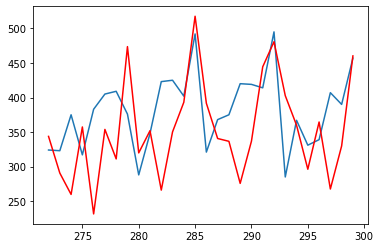

processing: HOUSEHOLD_1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with Sarima
701 701
Train on 270 samples, validate on 30 samples
Epoch 1/500
270/270 [==============================] - 0s 585us/step - loss: 0.4926 - val_loss: 0.1057
Epoch 2/500
270/270 [==============================] - 0s 22us/step - loss: 0.1045 - val_loss: 0.0119
Epoch 3/500
270/270 [==============================] - 0s 22us/step - loss: 0.0127 - val_loss: 0.0832
Epoch 4/500
270/270 [==============================] - 0s 19us/step - loss: 0.0860 - val_loss: 0.1210
Epoch 5/500
270/270 [==============================] - 0s 19us/step - loss: 0.1243 - val_loss: 0.0967
Epoch 6/500
270/270 [==============================] - 0s 22us/step - loss: 0.0996 - val_loss: 0.0514
Epoch 7/500
270/270 [==============================] - 0s 22us/step - loss: 0.0535 - val_loss: 0.0183
Epoch 8/500
270/270 [==============================] - 0s 22us/step - loss: 0.0194 - val_loss: 0.0107
Epoch 9/500
270/270 [==============================] - 0s 22us/step - loss: 0.0110 - val_loss: 0.0237
Epoch 10/50

Epoch 80/500
270/270 [==============================] - 0s 15us/step - loss: 0.0105 - val_loss: 0.0103
Epoch 81/500
270/270 [==============================] - 0s 19us/step - loss: 0.0105 - val_loss: 0.0103
Epoch 82/500
270/270 [==============================] - 0s 19us/step - loss: 0.0104 - val_loss: 0.0102
Epoch 83/500
270/270 [==============================] - 0s 19us/step - loss: 0.0104 - val_loss: 0.0102
Epoch 84/500
270/270 [==============================] - 0s 22us/step - loss: 0.0104 - val_loss: 0.0102
Epoch 85/500
270/270 [==============================] - 0s 22us/step - loss: 0.0104 - val_loss: 0.0102
Epoch 86/500
270/270 [==============================] - 0s 19us/step - loss: 0.0104 - val_loss: 0.0102
Epoch 87/500
270/270 [==============================] - 0s 19us/step - loss: 0.0104 - val_loss: 0.0102
Epoch 88/500
270/270 [==============================] - 0s 15us/step - loss: 0.0104 - val_loss: 0.0102
Epoch 89/500
270/270 [==============================] - 0s 19us/step - lo

Epoch 159/500
270/270 [==============================] - 0s 15us/step - loss: 0.0100 - val_loss: 0.0100
Epoch 160/500
270/270 [==============================] - 0s 19us/step - loss: 0.0099 - val_loss: 0.0100
Epoch 161/500
270/270 [==============================] - 0s 15us/step - loss: 0.0099 - val_loss: 0.0100
Epoch 162/500
270/270 [==============================] - 0s 15us/step - loss: 0.0099 - val_loss: 0.0099
Epoch 163/500
270/270 [==============================] - 0s 15us/step - loss: 0.0099 - val_loss: 0.0099
Epoch 164/500
270/270 [==============================] - 0s 15us/step - loss: 0.0099 - val_loss: 0.0099
Epoch 165/500
270/270 [==============================] - 0s 19us/step - loss: 0.0099 - val_loss: 0.0099
Epoch 166/500
270/270 [==============================] - 0s 19us/step - loss: 0.0099 - val_loss: 0.0099
Epoch 167/500
270/270 [==============================] - 0s 15us/step - loss: 0.0099 - val_loss: 0.0099
Epoch 168/500
270/270 [==============================] - 0s 22us

Epoch 238/500
270/270 [==============================] - 0s 19us/step - loss: 0.0085 - val_loss: 0.0092
Epoch 239/500
270/270 [==============================] - 0s 19us/step - loss: 0.0084 - val_loss: 0.0092
Epoch 240/500
270/270 [==============================] - 0s 15us/step - loss: 0.0084 - val_loss: 0.0092
Epoch 241/500
270/270 [==============================] - 0s 19us/step - loss: 0.0084 - val_loss: 0.0091
Epoch 242/500
270/270 [==============================] - 0s 19us/step - loss: 0.0083 - val_loss: 0.0091
Epoch 243/500
270/270 [==============================] - 0s 22us/step - loss: 0.0083 - val_loss: 0.0091
Epoch 244/500
270/270 [==============================] - 0s 19us/step - loss: 0.0083 - val_loss: 0.0091
Epoch 245/500
270/270 [==============================] - 0s 15us/step - loss: 0.0082 - val_loss: 0.0091
Epoch 246/500
270/270 [==============================] - 0s 19us/step - loss: 0.0082 - val_loss: 0.0091
Epoch 247/500
270/270 [==============================] - 0s 19us

Epoch 317/500
270/270 [==============================] - 0s 15us/step - loss: 0.0051 - val_loss: 0.0080
Epoch 318/500
270/270 [==============================] - 0s 19us/step - loss: 0.0050 - val_loss: 0.0080
Epoch 319/500
270/270 [==============================] - 0s 15us/step - loss: 0.0050 - val_loss: 0.0080
Epoch 320/500
270/270 [==============================] - 0s 22us/step - loss: 0.0050 - val_loss: 0.0080
Epoch 321/500
270/270 [==============================] - 0s 15us/step - loss: 0.0049 - val_loss: 0.0080
Epoch 322/500
270/270 [==============================] - 0s 19us/step - loss: 0.0049 - val_loss: 0.0080
Epoch 323/500
270/270 [==============================] - 0s 19us/step - loss: 0.0048 - val_loss: 0.0080
Epoch 324/500
270/270 [==============================] - 0s 19us/step - loss: 0.0048 - val_loss: 0.0080
Epoch 325/500
270/270 [==============================] - 0s 19us/step - loss: 0.0048 - val_loss: 0.0080
Epoch 326/500
270/270 [==============================] - 0s 19us

Epoch 396/500
270/270 [==============================] - 0s 22us/step - loss: 0.0033 - val_loss: 0.0088
Epoch 397/500
270/270 [==============================] - 0s 19us/step - loss: 0.0029 - val_loss: 0.0088
Epoch 398/500
270/270 [==============================] - 0s 22us/step - loss: 0.0030 - val_loss: 0.0095
Epoch 399/500
270/270 [==============================] - 0s 19us/step - loss: 0.0031 - val_loss: 0.0089
Epoch 400/500
270/270 [==============================] - 0s 19us/step - loss: 0.0027 - val_loss: 0.0089
Epoch 401/500
270/270 [==============================] - 0s 22us/step - loss: 0.0030 - val_loss: 0.0092
Epoch 402/500
270/270 [==============================] - 0s 19us/step - loss: 0.0028 - val_loss: 0.0092
Epoch 403/500
270/270 [==============================] - 0s 22us/step - loss: 0.0028 - val_loss: 0.0089
Epoch 404/500
270/270 [==============================] - 0s 22us/step - loss: 0.0029 - val_loss: 0.0089
Epoch 405/500
270/270 [==============================] - 0s 26us

Epoch 475/500
270/270 [==============================] - 0s 19us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 476/500
270/270 [==============================] - 0s 26us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 477/500
270/270 [==============================] - 0s 19us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 478/500
270/270 [==============================] - 0s 22us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 479/500
270/270 [==============================] - 0s 19us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 480/500
270/270 [==============================] - 0s 22us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 481/500
270/270 [==============================] - 0s 19us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 482/500
270/270 [==============================] - 0s 19us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 483/500
270/270 [==============================] - 0s 19us/step - loss: 0.0019 - val_loss: 0.0099
Epoch 484/500
270/270 [==============================] - 0s 26us

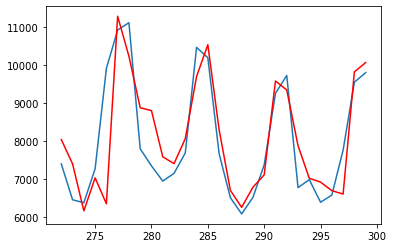

processing: HOUSEHOLD_2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with Sarima
701 701
Train on 270 samples, validate on 30 samples
Epoch 1/500
270/270 [==============================] - 0s 596us/step - loss: 0.2275 - val_loss: 0.0250
Epoch 2/500
270/270 [==============================] - 0s 33us/step - loss: 0.0272 - val_loss: 0.0643
Epoch 3/500
270/270 [==============================] - 0s 22us/step - loss: 0.0522 - val_loss: 0.1028
Epoch 4/500
270/270 [==============================] - 0s 19us/step - loss: 0.0870 - val_loss: 0.0778
Epoch 5/500
270/270 [==============================] - 0s 19us/step - loss: 0.0641 - val_loss: 0.0378
Epoch 6/500
270/270 [==============================] - 0s 19us/step - loss: 0.0291 - val_loss: 0.0204
Epoch 7/500
270/270 [==============================] - 0s 22us/step - loss: 0.0180 - val_loss: 0.0281
Epoch 8/500
270/270 [==============================] - 0s 22us/step - loss: 0.0312 - val_loss: 0.0406
Epoch 9/500
270/270 [==============================] - 0s 22us/step - loss: 0.0469 - val_loss: 0.0423
Epoch 10/50

Epoch 80/500
270/270 [==============================] - 0s 37us/step - loss: 0.0169 - val_loss: 0.0198
Epoch 81/500
270/270 [==============================] - 0s 33us/step - loss: 0.0169 - val_loss: 0.0197
Epoch 82/500
270/270 [==============================] - 0s 22us/step - loss: 0.0168 - val_loss: 0.0195
Epoch 83/500
270/270 [==============================] - 0s 37us/step - loss: 0.0168 - val_loss: 0.0194
Epoch 84/500
270/270 [==============================] - 0s 30us/step - loss: 0.0168 - val_loss: 0.0193
Epoch 85/500
270/270 [==============================] - 0s 44us/step - loss: 0.0168 - val_loss: 0.0192
Epoch 86/500
270/270 [==============================] - 0s 56us/step - loss: 0.0167 - val_loss: 0.0192
Epoch 87/500
270/270 [==============================] - 0s 22us/step - loss: 0.0167 - val_loss: 0.0192
Epoch 88/500
270/270 [==============================] - 0s 30us/step - loss: 0.0167 - val_loss: 0.0192
Epoch 89/500
270/270 [==============================] - 0s 30us/step - lo

Epoch 159/500
270/270 [==============================] - 0s 26us/step - loss: 0.0122 - val_loss: 0.0154
Epoch 160/500
270/270 [==============================] - 0s 30us/step - loss: 0.0121 - val_loss: 0.0153
Epoch 161/500
270/270 [==============================] - 0s 22us/step - loss: 0.0120 - val_loss: 0.0153
Epoch 162/500
270/270 [==============================] - 0s 19us/step - loss: 0.0119 - val_loss: 0.0152
Epoch 163/500
270/270 [==============================] - 0s 33us/step - loss: 0.0118 - val_loss: 0.0151
Epoch 164/500
270/270 [==============================] - 0s 26us/step - loss: 0.0116 - val_loss: 0.0151
Epoch 165/500
270/270 [==============================] - 0s 26us/step - loss: 0.0115 - val_loss: 0.0150
Epoch 166/500
270/270 [==============================] - 0s 22us/step - loss: 0.0114 - val_loss: 0.0149
Epoch 167/500
270/270 [==============================] - 0s 26us/step - loss: 0.0113 - val_loss: 0.0148
Epoch 168/500
270/270 [==============================] - 0s 26us

Epoch 238/500
270/270 [==============================] - 0s 30us/step - loss: 0.0094 - val_loss: 0.0148
Epoch 239/500
270/270 [==============================] - 0s 26us/step - loss: 0.0050 - val_loss: 0.0152
Epoch 240/500
270/270 [==============================] - 0s 26us/step - loss: 0.0085 - val_loss: 0.0155
Epoch 241/500
270/270 [==============================] - 0s 22us/step - loss: 0.0051 - val_loss: 0.0208
Epoch 242/500
270/270 [==============================] - 0s 26us/step - loss: 0.0078 - val_loss: 0.0148
Epoch 243/500
270/270 [==============================] - 0s 33us/step - loss: 0.0050 - val_loss: 0.0146
Epoch 244/500
270/270 [==============================] - 0s 59us/step - loss: 0.0072 - val_loss: 0.0154
Epoch 245/500
270/270 [==============================] - 0s 30us/step - loss: 0.0050 - val_loss: 0.0193
Epoch 246/500
270/270 [==============================] - 0s 19us/step - loss: 0.0068 - val_loss: 0.0150
Epoch 247/500
270/270 [==============================] - 0s 19us

Epoch 317/500
270/270 [==============================] - 0s 30us/step - loss: 0.0029 - val_loss: 0.0170
Epoch 318/500
270/270 [==============================] - 0s 30us/step - loss: 0.0029 - val_loss: 0.0169
Epoch 319/500
270/270 [==============================] - 0s 41us/step - loss: 0.0029 - val_loss: 0.0169
Epoch 320/500
270/270 [==============================] - 0s 44us/step - loss: 0.0028 - val_loss: 0.0170
Epoch 321/500
270/270 [==============================] - 0s 30us/step - loss: 0.0028 - val_loss: 0.0169
Epoch 322/500
270/270 [==============================] - 0s 26us/step - loss: 0.0028 - val_loss: 0.0171
Epoch 323/500
270/270 [==============================] - 0s 26us/step - loss: 0.0028 - val_loss: 0.0170
Epoch 324/500
270/270 [==============================] - 0s 26us/step - loss: 0.0028 - val_loss: 0.0171
Epoch 325/500
270/270 [==============================] - 0s 19us/step - loss: 0.0027 - val_loss: 0.0172
Epoch 326/500
270/270 [==============================] - 0s 33us

Epoch 396/500
270/270 [==============================] - 0s 59us/step - loss: 0.0021 - val_loss: 0.0169
Epoch 397/500
270/270 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0179
Epoch 398/500
270/270 [==============================] - 0s 52us/step - loss: 0.0021 - val_loss: 0.0183
Epoch 399/500
270/270 [==============================] - 0s 26us/step - loss: 0.0022 - val_loss: 0.0171
Epoch 400/500
270/270 [==============================] - 0s 26us/step - loss: 0.0021 - val_loss: 0.0173
Epoch 401/500
270/270 [==============================] - 0s 22us/step - loss: 0.0020 - val_loss: 0.0185
Epoch 402/500
270/270 [==============================] - 0s 26us/step - loss: 0.0021 - val_loss: 0.0176
Epoch 403/500
270/270 [==============================] - 0s 22us/step - loss: 0.0019 - val_loss: 0.0172
Epoch 404/500
270/270 [==============================] - 0s 22us/step - loss: 0.0020 - val_loss: 0.0181
Epoch 405/500
270/270 [==============================] - 0s 107u

Epoch 475/500
270/270 [==============================] - 0s 26us/step - loss: 0.0013 - val_loss: 0.0194
Epoch 476/500
270/270 [==============================] - 0s 37us/step - loss: 0.0013 - val_loss: 0.0194
Epoch 477/500
270/270 [==============================] - 0s 26us/step - loss: 0.0013 - val_loss: 0.0194
Epoch 478/500
270/270 [==============================] - 0s 22us/step - loss: 0.0013 - val_loss: 0.0195
Epoch 479/500
270/270 [==============================] - 0s 26us/step - loss: 0.0012 - val_loss: 0.0195
Epoch 480/500
270/270 [==============================] - 0s 81us/step - loss: 0.0012 - val_loss: 0.0195
Epoch 481/500
270/270 [==============================] - 0s 26us/step - loss: 0.0012 - val_loss: 0.0195
Epoch 482/500
270/270 [==============================] - 0s 22us/step - loss: 0.0012 - val_loss: 0.0195
Epoch 483/500
270/270 [==============================] - 0s 30us/step - loss: 0.0012 - val_loss: 0.0195
Epoch 484/500
270/270 [==============================] - 0s 33us

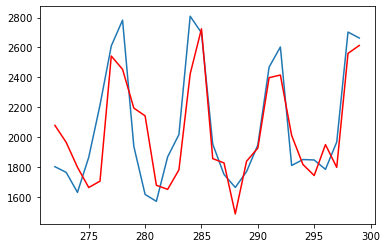

In [18]:
dept_param_order          = {
                                'FOODS_1'    :(5,1,3), 
                                'FOODS_2'    :(5,1,2), 
                                'FOODS_3'    :(5,1,4), 
                                'HOBBIES_1'  :(2,1,1), 
                                'HOBBIES_2'  :(1,1,3), 
                                'HOUSEHOLD_1':(3,1,1),
                                'HOUSEHOLD_2':(3,1,1)
                            }
dept_param_seasonal_order = {
                             'FOODS_1'    :(2,0,0,7), 
                             'FOODS_2'    :(2,0,1,7), 
                             'FOODS_3'    :(1,0,2,7),
                             'HOBBIES_1'  :(2,0,2,7), 
                             'HOBBIES_2'  :(1,0,0,7),
                             'HOUSEHOLD_1':(2,0,2,7),
                             'HOUSEHOLD_2':(2,0,0,7)
                            }
for dept in dept_ids:
    print('processing:', dept)
    df = data_dummy[data_dummy['dept_id'] == dept]
    df.drop('dept_id', axis=1, inplace=True)
    test_len    = 701
#     train_      = df[0:len(df)-test_len]
    test_       = df[len(df)-test_len:]
    pred_sarima, resid_test = sarima_rolling_forecast(df, test_, dept_param_order[dept], dept_param_seasonal_order[dept])
    print ('Done with Sarima')
    lstm_test_len = 300
    first_stp     = test_len -lstm_test_len 
    pred_lstm     = pred_resid_lstm(list(resid_test), lstm_test_len)
    pred_lstm['SARIMA Pred']       = pred_sarima[first_stp:]
    pred_lstm['Actual Sales']      = test_['sales'].values[first_stp:]
    pred_lstm['SARIMA LSTM Pred']  = pred_lstm['resid_rescale'] + pred_lstm['SARIMA Pred']
    
    error_rmse = sqrt(mse(pred_lstm['SARIMA LSTM Pred'],pred_lstm['Actual Sales']))
    print('for all Test RMSE: %.3f' % error_rmse)
    
    error_rmse_28 = sqrt(mse(pred_lstm['SARIMA LSTM Pred'].tail(28),pred_lstm['Actual Sales'].tail(28)))
    print('for 28 days Test RMSE: %.3f' % error_rmse_28)
    
    pred_lstm.to_csv(dept+'_results.csv', index=False)
    
    Y    = pred_lstm['Actual Sales'].tail(28)
    pred = pred_lstm['SARIMA LSTM Pred'].tail(28)
    plt.plot(Y)
    plt.plot(pred , color = 'r')
    plt.show()